In [ ]:
!pip install sqlalchemy


C:\Users\anaca\AppData\Local\Temp\ipykernel_21756\1821613307.py:14: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


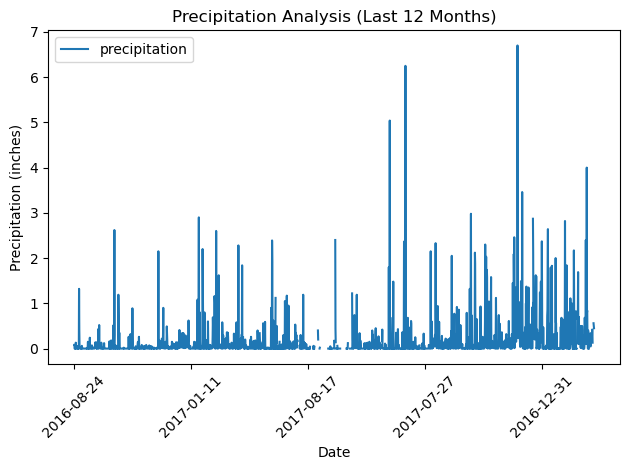

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


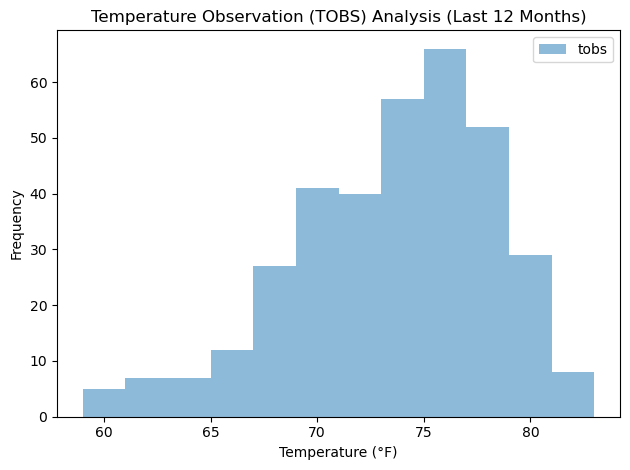

In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import datetime as dt

# Create engine to connect to SQLite database
engine = create_engine("sqlite:///hawaii.sqlite")

# Reflect database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)

# Save references to the classes
Station = Base.classes.station
Measurement = Base.classes.measurement

# Create a session
session = Session(engine)

# Precipitation Analysis

# Find the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculate the date one year ago from the most recent date
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Query for the last year of precipitation data
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Create a DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)

# Plot the results
precipitation_df.plot(rot=45)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Analysis (Last 12 Months)")
plt.tight_layout()
plt.show()

# Print summary statistics
summary_statistics = precipitation_df.describe()
print(summary_statistics)

# Station Analysis

# Calculate the number of stations
num_stations = session.query(Station.station).count()

# List stations and observation counts in descending order
station_obs_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Identify the most active station
most_active_station = station_obs_counts[0][0]

# Find min, max, and average temperatures for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Design a query to get the previous 12 months of TOBS data for the most active station
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Create a DataFrame for TOBS data
tobs_df = pd.DataFrame(tobs_data, columns=['date', 'tobs'])

# Plot histogram
tobs_df.plot.hist(bins=12, alpha=0.5)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title("Temperature Observation (TOBS) Analysis (Last 12 Months)")
plt.tight_layout()
plt.show()

# Close the session
session.close()
